In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### <font style="color:green">Extract the data</font>

In [2]:
!mkdir Amostra
!cp /content/drive/My\ Drive/Resnet/Amostra_6_classes_split_v3.zip /content/Amostra/
%cd /content/Amostra/
!unzip -q Amostra_6_classes_split_v3.zip
!rm /content/Amostra/Amostra_6_classes_split_v3.zip

/content/Amostra


In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [0]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

from torch.optim import lr_scheduler

### <font style="color:green">3.2.1. Compulsary preprocessing transforms</font>

In [0]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [0]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

In [0]:
def data_augmentation_preprocess(mean, std):
    
    initail_transoform = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90)
        ])
    
    common_transforms = image_common_transforms(mean, std)
                
    aug_transforms = transforms.Compose([
        initail_transoform,
        transforms.RandomGrayscale(p=0.1),
        common_transforms
        ])
    
    return aug_transforms

### <font style="color:green">3.2.3. Mean and STD</font>

In [0]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

In [0]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [0]:
def subset_data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    data_subset = torch.utils.data.Subset(dataset,np.arange(0,len(dataset),1./subset_size).astype(int))

    loader = torch.utils.data.DataLoader(data_subset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [0]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = image_common_transforms(mean, std) 
        
    # train dataloader
    #train_loader = subset_data_loader(train_data_path, train_transforms, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
    #                   subset_size=0.2)
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')

    mean_test, std_test = get_mean_std(data_root=test_data_path, num_workers=num_workers)

    common_transforms_test = image_common_transforms(mean_test, std_test)    


    #test_loader = subset_data_loader(test_data_path, common_transforms_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
    #                   subset_size=0.2)
    test_loader = data_loader(test_data_path, 
                              common_transforms_test, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)

    return train_loader, test_loader

In [0]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [0]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 500 
    epochs_count: int = 50  
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    decay_rate: float = 0.1
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/content/Amostra" 
    num_workers: int = 2 
    device: str = 'cuda'  
    dst_root: str = '/content/drive/My Drive/Resnet/8.2-classificacao_v5(6_classes)/6_classes'
    


In [0]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.5. Load the Model</font>

In [0]:
def load_model(model, model_dir='models', model_file_name='CIPP_classifier_6_classes.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:red">4.8. Define Model [20 Points]</font>

In the section, you will define the CNN model. You need to keep iterating by training various models by changing:
    - Number of layers
    - Parameters inside the layers
    - different types of layers

In [0]:
def pretrained_resnet50(transfer_learning=True, num_class=6):
    resnet = models.resnet50(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet

In [18]:
model = pretrained_resnet50()


# get optimizer
train_config = TrainingConfiguration()

### CHANGE HERE ###

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

decay_rate=train_config.decay_rate

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


## <font style="color:blue">5.1. Make Predictions</font>

In [0]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()
    

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get predictions on a batch</font>

In [0]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    #print(cls)
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    
    os.chdir(training_configuration.dst_root)
    fig.savefig('sample_prediction.png')
    os.chdir(training_configuration.data_root)
    plt.show()
    
    return
        
    

In [0]:
def get_all_prediction(model, data_root, mean, std,batch_size = 1000):
    

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    #test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    #interval = int(data_len/batch_size)
    
    #imgs = []
    inputs = []
    targets = []
    cls = []
    prob = []

    for i in range(data_len):
        #index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(i)
        
        inputs.append(trans_input)
        targets.append(target)
        if((i+1)%batch_size==0 or (i+1)==data_len):
            #print(i,batch_size,(i+1)%batch_size,data_len)
            inputs = torch.stack(inputs)
            cls_batch, prob_batch = prediction(model, device, batch_input=inputs)
            cls.extend(cls_batch)
            prob.extend(prob_batch)
            
            inputs = []
        #print(len(cls), len(prob),  len(targets), data_len)
   
    return targets, cls, prob
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

In [22]:
train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')

train_data_path = os.path.join(train_config.data_root, 'training')

m = pretrained_resnet50()
os.chdir(train_config.dst_root)
#m = load_model(m)
os.chdir(train_config.data_root)




mean, std = get_mean_std(train_data_path)


#get_sample_prediction(m, test_data_path, mean, std)

mean: tensor([0.4989, 0.4909, 0.4811]), std: tensor([0.1985, 0.1947, 0.1935])


You can see that even though the network is trained on a very small subset if data, the predictions are not that bad. This means that our model is ready to be trained.

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusão Normalizada'
        else:
            title = 'Matriz de confusão'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Rótulo Real',
           xlabel='Rótulo Previsto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:

# transformed data
test_dataset_trans = datasets.ImageFolder(root=test_data_path, transform=image_common_transforms(mean, std))

# original image dataset
test_dataset = datasets.ImageFolder(root=test_data_path, transform=image_preprocess_transforms())
m5=load_model(m, model_file_name='/content/drive/My Drive/Resnet/8.2-classificacao_v5(6_classes)/6_classes/models/CIPP_classifier_6_classes_v5.pt')
targets_v5, cls_v5, prob_v5=get_all_prediction(m5, data_root=test_data_path, mean=mean, std=std,batch_size = 500)
m4=load_model(m, model_file_name='/content/drive/My Drive/Resnet/8.2-classificacao_v5(6_classes)/6_classes/models/CIPP_classifier_6_classes_v4.pt')
targets_v4, cls_v4, prob_v4=get_all_prediction(m4, data_root=test_data_path, mean=mean, std=std,batch_size = 500)

Matriz de confusão


<Figure size 3600x3600 with 0 Axes>

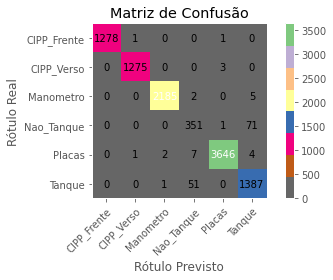

Matriz de confusão normalizada


<Figure size 7200x7200 with 0 Axes>

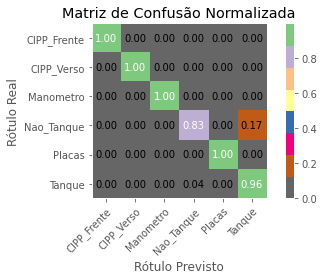

In [49]:
cls=cls_v5.copy()
prob=prob_v5.copy()
targets=targets_v5.copy()

classes=test_dataset.classes.copy()
classes.append('Impreciso')
cls_copy=cls.copy()
for i in range(len(cls)):
  if(prob[i]<0.35):
    cls_copy[i]=6


# Plot non-normalized confusion matrix


plt.figure(figsize=(50,50))
plot_confusion_matrix(targets, cls_copy, classes=classes, 
                      title='Matriz de Confusão',cmap=plt.cm.Accent_r) 
plt.grid(False)
os.chdir(train_config.dst_root)
plt.savefig('matriz_confusao_classe_6_n_normalized_35_confidence_v5.png')
os.chdir(train_config.data_root)

plt.show()


plt.figure(figsize=(100,100))
plot_confusion_matrix(targets, cls_copy, classes=classes, normalize='True',
                      title='Matriz de Confusão Normalizada',cmap=plt.cm.Accent_r) 
plt.grid(False)
os.chdir(train_config.dst_root)
plt.savefig('matriz_confusao_classe_6_normalized_35_confidence_v5.png')
os.chdir(train_config.data_root)

